# Анализ доходности активов с использованием бутстрапированной регрессионной модели Фамы-Френча 


Постановка задачи. Чтобы проанализировать доходность активов с использованием трехфакторной модели Фамы-Френча, сделайте вывод о взаимосвязи между активом и рыночными факторами и предоставьте интервальную оценку доходности с помощью бутстреп-регрессии. Трехфакторная модель Фамы-Френча состоит из трех независимых переменных — рыночной премии или доходности рыночного портфеля (представленной индексом типа S&P 500), премии за размер или доходности портфеля небольших компаний (теоретически в среднем небольшие компании имеют более высокую доходность, чем крупные компании), а также премию за стоимость или доходность компаний с высоким соотношением балансовой стоимости к рынку (так называемые стоимостные акции) по сравнению с компаниями с низким соотношением балансовой стоимости к рынку и доходностью активов в качестве зависимой переменной в модели. Таким образом, модель Фамы-Френча позволяет измерить доходность активов с поправкой на риск путем учета трех основных рыночных факторов, влияющих на доходность активов.

In [54]:
!pip install getFamaFrenchFactors


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [55]:
import statsmodels.api as sm
import math
import matplotlib.colors as mcolors
import pandas_datareader
from statsmodels.api import OLS
import getFamaFrenchFactors as gff
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from math import sqrt
import os
from scipy import stats
# os.system('pip install getFamaFrenchFactors')
# plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14, 10]

In [56]:
stocks_df = pd.read_csv('../data/market_data/s_and_p/sp500_stocks.csv')
df = stocks_df.pivot(
    index='Date', columns='Symbol', values='Adj Close')

df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

df.head()

Symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,20.122225,4.496877,6.470740,NaN,NaN,18.952158,7.994444,32.212463,37.090000,22.530378,...,52.883564,9.905467,41.538414,12.918812,40.237793,NaN,19.158094,52.587063,28.670000,NaN
2010-01-05,19.903641,5.005957,6.481928,NaN,NaN,18.799044,7.967778,32.411537,37.700001,22.494806,...,52.765034,10.115746,44.064743,12.765594,40.394901,NaN,19.092577,54.251747,28.620001,NaN
2010-01-06,19.832933,4.798555,6.378825,NaN,NaN,18.903440,7.933333,32.756092,37.619999,22.452118,...,53.614510,10.003899,43.486748,12.790112,40.744026,NaN,18.956091,54.234219,28.400000,NaN
2010-01-07,19.807213,4.939965,6.367032,NaN,NaN,19.060040,7.886667,32.725479,36.889999,22.274269,...,53.456459,9.959159,44.415436,12.734958,40.616020,NaN,18.950630,55.478359,27.690001,NaN
2010-01-08,19.800785,4.845691,6.409362,NaN,NaN,19.157482,7.871111,32.595295,36.689999,22.402325,...,53.397198,9.867442,44.097221,12.741084,40.453075,NaN,18.956091,54.313084,27.600000,NaN


In [57]:
tickers = ['GOOGL']

df[tickers]


Symbol,GOOGL
Date,
2010-01-04,15.684434
2010-01-05,15.615365
2010-01-06,15.221722
2010-01-07,14.867367
2010-01-08,15.065566
...,...
2024-04-30,162.779999
2024-05-01,163.860001
2024-05-02,166.619995


Text(0.5, 1.0, 'Logarithmic price')

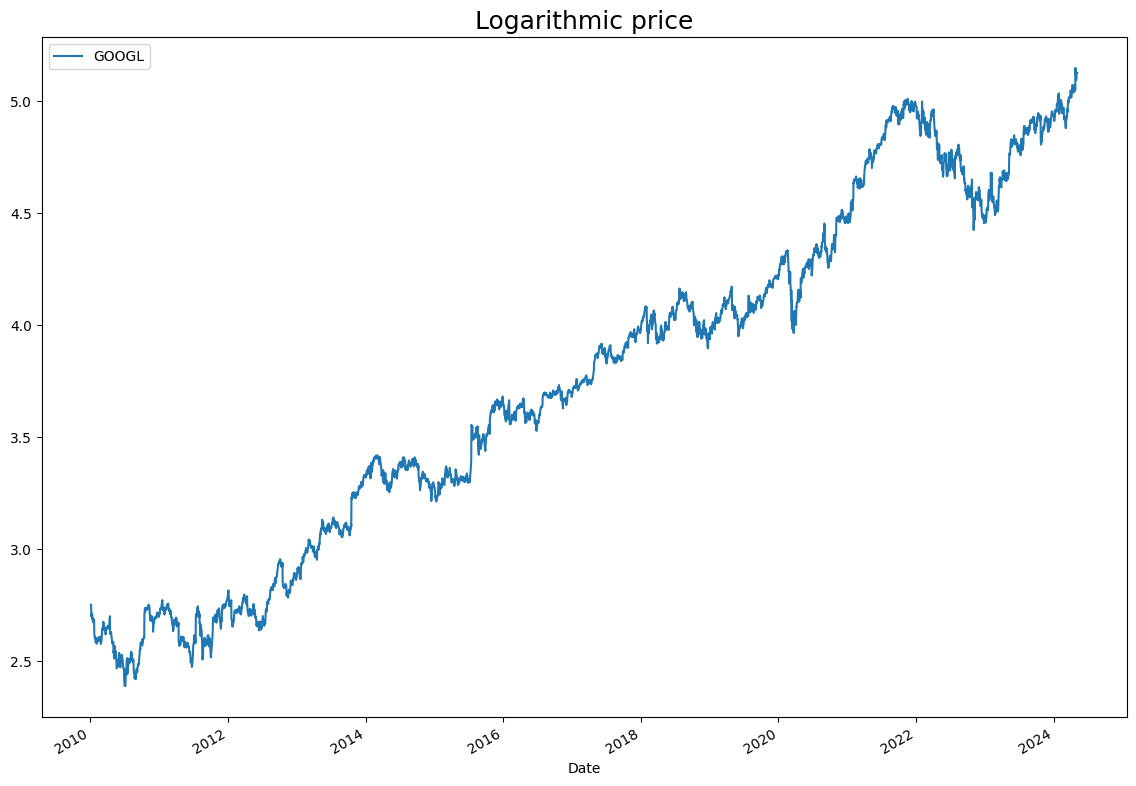

In [58]:
plt.figure()
np.log(df[tickers[0]]).plot()
plt.legend(loc='best')
plt.title('Logarithmic price', fontsize=18)

Text(0.5, 0.98, 'Plots of historical returns')

<Figure size 1400x1000 with 0 Axes>

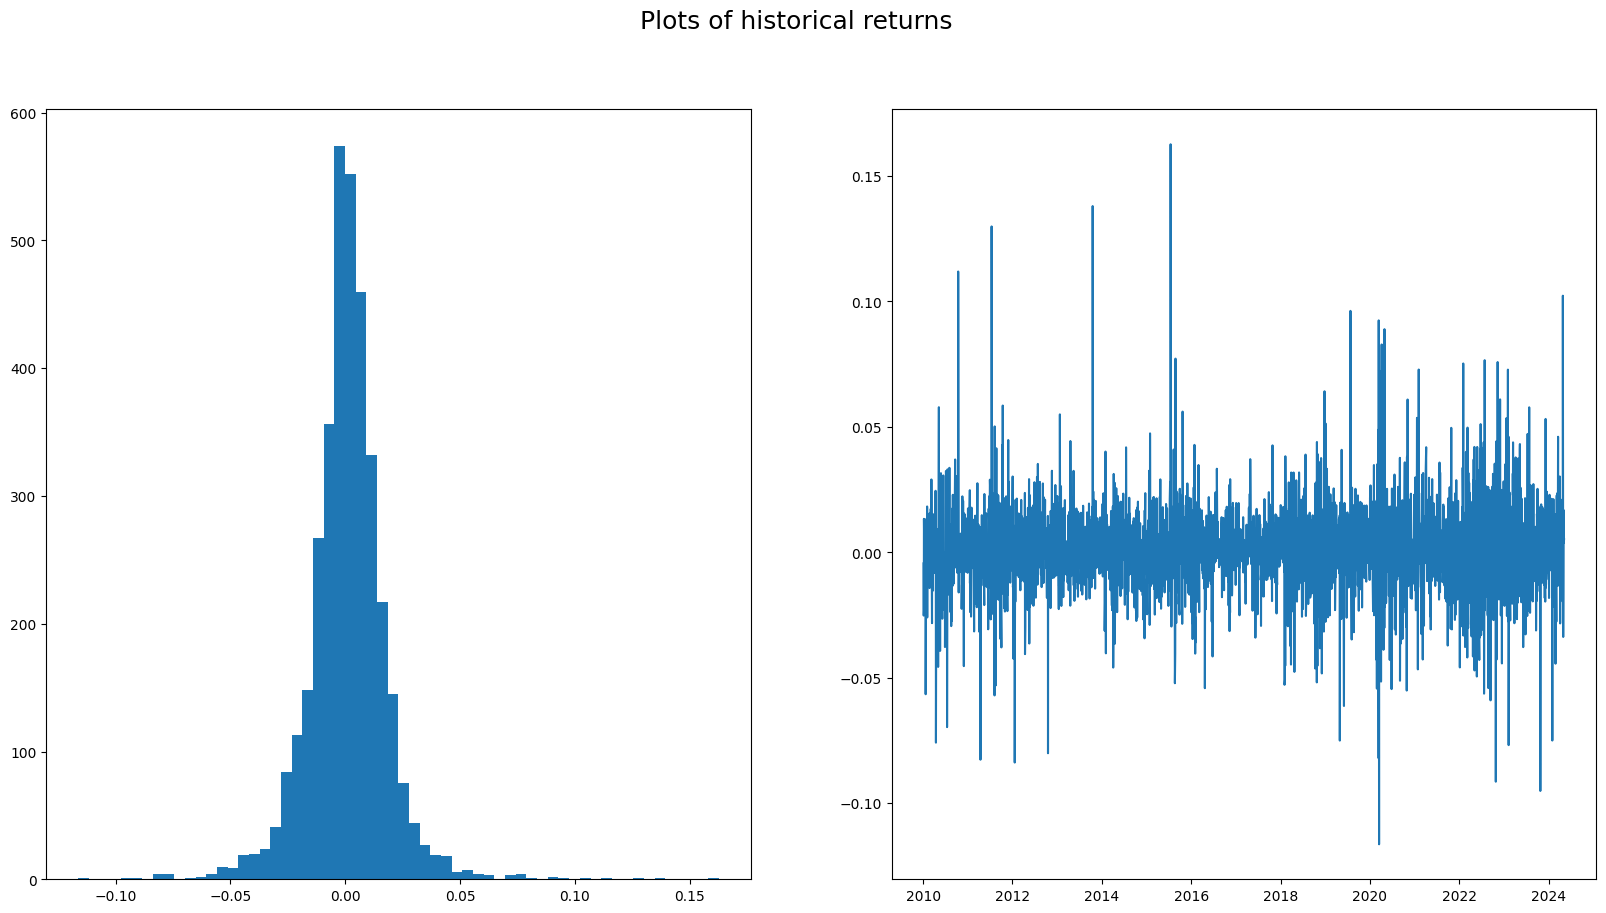

In [59]:
def rets(x):
    return (x - x.shift(1))/x.shift(1)


returns = pd.DataFrame(df[tickers[0]]).apply(rets)

# lets get plots of the daily returns:
plt.figure()
fig1, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].hist(returns, bins=round(sqrt(len(returns))))
axs[1].plot(returns)
fig1.suptitle('Plots of historical returns', fontsize=18)

ADF Statistic: -15.418684
p-value: 0.000000


<Figure size 1400x1000 with 0 Axes>

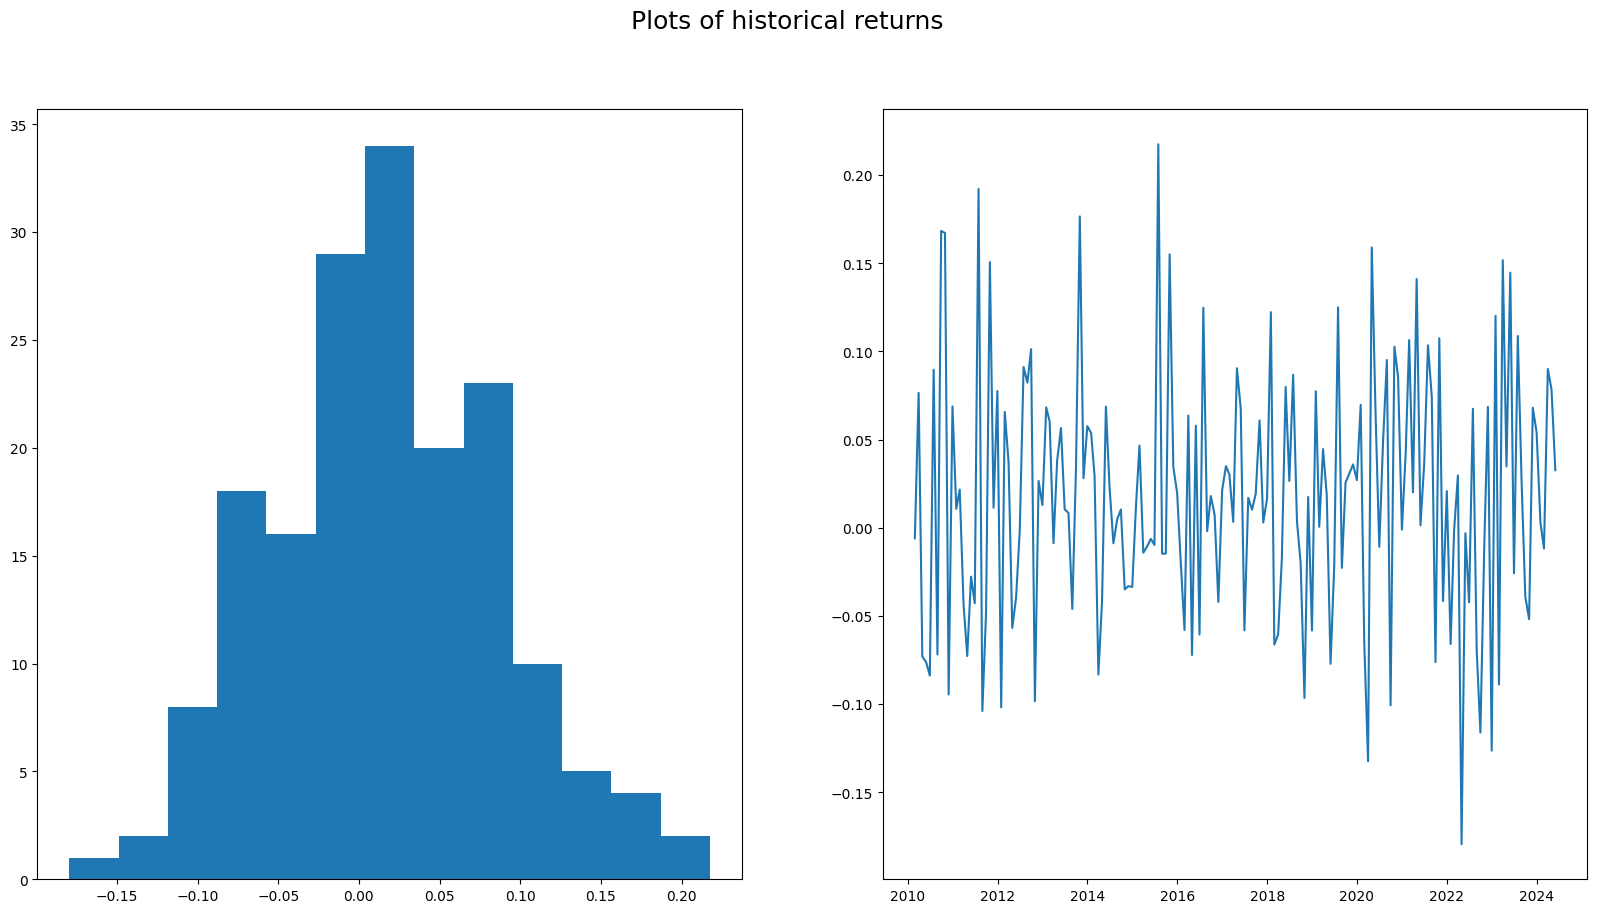

In [60]:
mon = pd.DataFrame(df[tickers[0]]).resample('ME').last()
mon_rets = mon.pct_change().dropna()

# plots of montly rets:
plt.figure()
fig2, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].hist(mon_rets, bins=round(sqrt(len(mon_rets))))
axs[1].plot(mon_rets)
fig2.suptitle('Plots of historical returns', fontsize=18)

# stationarity test
adf = adfuller(mon_rets)
print('ADF Statistic: %f' % adf[0])
print('p-value: %f' % adf[1])

In [61]:
# get Fama French factors
ff3 = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))

# create a seq of dates
# date_seq = pd.date_range(start=start, end=end, freq='M')

# set date columns
ff3 = ff3.rename(columns={'date_ff_factors': 'Date'})

# merge data together
data = pd.merge(mon_rets, ff3, on='Date', how='left')
data = data.set_index('Date')

# do an NA check:
print('Missing values in the data: ', data.isna().sum())

Missing values in the data:  GOOGL     0
Mkt-RF    2
SMB       2
HML       2
RF        2
dtype: int64


In [62]:
data = data.dropna()

In [63]:
data.head()

,GOOGL,Mkt-RF,SMB,HML,RF
Date,,,,,
2010-02-28,-0.005925,0.0340,0.0119,0.0323,0.0000
2010-03-31,0.076538,0.0631,0.0148,0.0221,0.0001
2010-04-30,-0.073036,0.0200,0.0487,0.0289,0.0001
2010-05-31,-0.076222,-0.0789,0.0009,-0.0244,0.0001
2010-06-30,-0.083767,-0.0557,-0.0182,-0.0470,0.0001


GOOGL correlation with market index: 0.6272493376926205
GOOGL correlation with small-company portfolio index: 0.056016922225584465
GOOGL correlation with value stocks index: -0.09387154917780662


<Figure size 2000x1000 with 0 Axes>

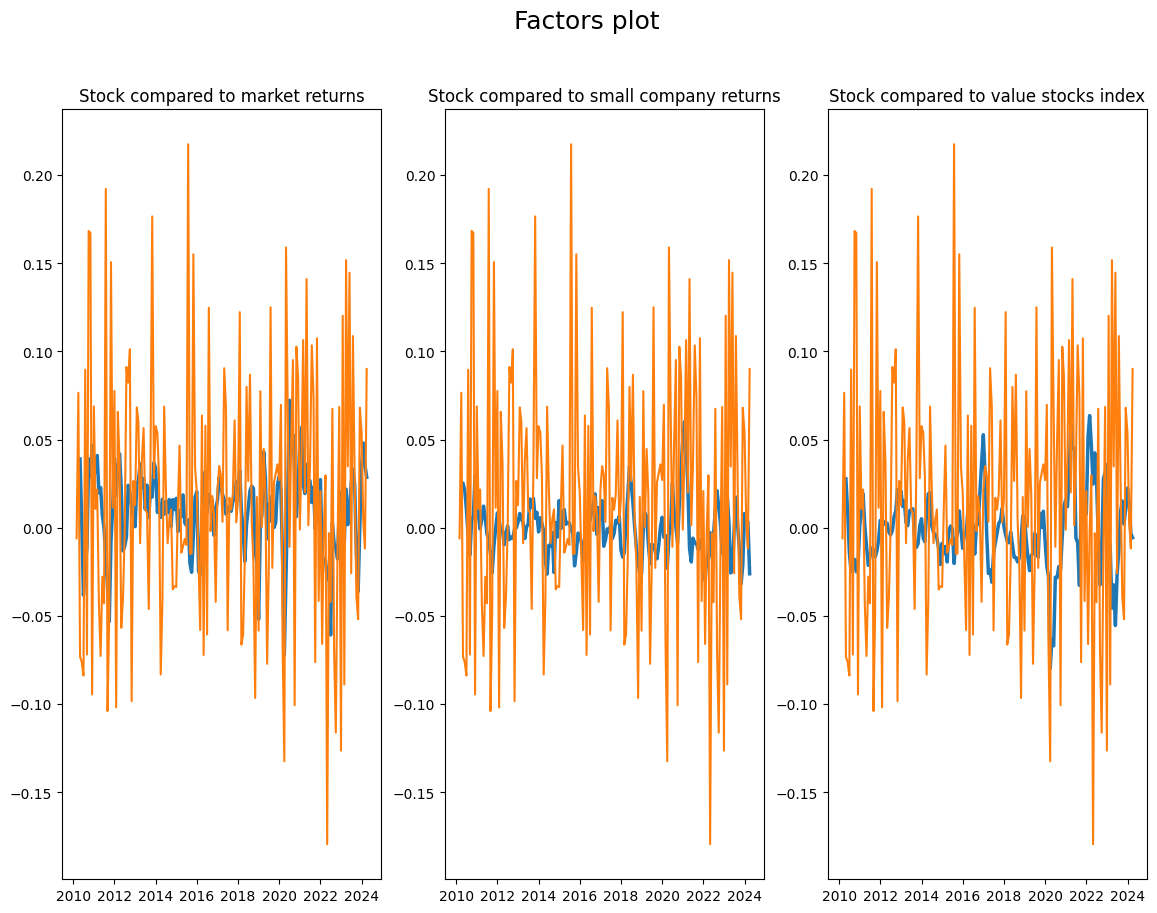

In [64]:
# Assuming 'data' is defined elsewhere in your code and contains the necessary data
stock = tickers[0]
factors = ['Mkt-RF', 'SMB', 'HML']

# Plot Fama-French factors
plt.figure(figsize=(20, 10))
fig3, axs = plt.subplots(1, 3)
axs[0].plot(data['Mkt-RF'].rolling(3).mean(), linewidth=2.5)
axs[0].plot(data[stock])
axs[0].set_title('Stock compared to market returns')
axs[1].plot(data['SMB'].rolling(3).mean(), linewidth=2.5)
axs[1].plot(data[stock])
axs[1].set_title('Stock compared to small company returns')
axs[2].plot(data['HML'].rolling(3).mean(), linewidth=2.5)
axs[2].plot(data[stock])
axs[2].set_title('Stock compared to value stocks index')
fig3.suptitle('Factors plot', fontsize=18)

# Calculate correlations
cor = data.corr()

# Use.iloc[] to access values by their integer location
print(f'{stock} correlation with market index:', cor['Mkt-RF'].iloc[0])
print(f'{stock} correlation with small-company portfolio index:',
      cor['SMB'].iloc[0])
print(f'{stock} correlation with value stocks index:', cor['HML'].iloc[0])

In [65]:
Y = data[tickers[0]] - data['RF']  # substract the risk free rate

X = data[factors]

# build model
model = sm.OLS(Y, sm.tools.add_constant(X))
result = model.fit()

# examine results
print(result.summary())

# obtain average values:
avr = ff3.drop('Date', axis=1).apply(np.mean)

# evaluate expected returns for facebook
Int, Mkt, SMB, HML = result.params

# here we drop the intercept, because it represents the excess return over the market
exp_returns = Mkt*avr['Mkt-RF'] + SMB*avr['SMB'] + HML*avr['HML']

e_rets = exp_returns - data['RF'].mean()

print(f'The expected monthly return for {stock} is:', e_rets)
print(f'The expected anual return for {stock} is:', ((1 + e_rets) ** 12) - 1)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     43.39
Date:                Thu, 09 May 2024   Prob (F-statistic):           9.36e-21
Time:                        21:33:52   Log-Likelihood:                 258.20
No. Observations:                 170   AIC:                            -508.4
Df Residuals:                     166   BIC:                            -495.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.004      0.736      0.4

Теперь у нас есть результаты регрессии на основе нашей 3-факторной модели. Значение $R^2$ составляет: 0.439, что означает, что на факторы Фамы-Френча приходится ~43% изменчивости актива. Статистика модели также указывает на нулевую автокорреляцию остатков, которые не имеют нормального распределения.

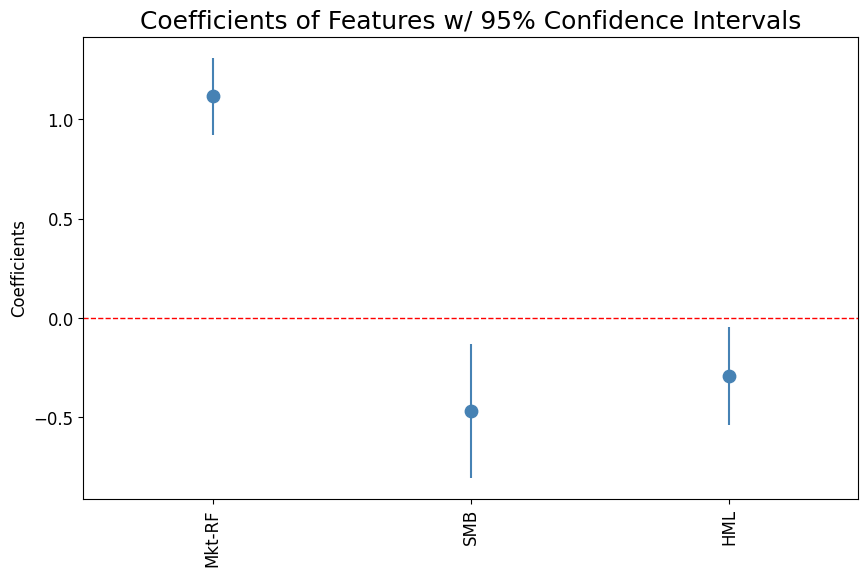

In [66]:
# create dataframe of results summary
coef_df = pd.DataFrame(result.summary().tables[1].data)
coef_df.columns = coef_df.iloc[0]

coef_df = coef_df.drop(0)  # drop the extra row with column labels
coef_df = coef_df.set_index(coef_df.columns[0])  # set index to variable names

# change datatype from object to float
coef_df = coef_df.astype(float)

# rename erros column
coef_df.rename(columns={'std err': 'std_err'}, inplace=True)

# Drop the constant for plotting purposes
coef_df.drop(['const'], inplace=True)

# add factors to the dataframe to ease plotting
coef_df['factors'] = factors
coef_df['er_interval'] = coef_df['std_err']*1.959

# Plot coefficients
fig, ax = plt.subplots(figsize=(10, 6))

coef_df.plot(x='factors', y='coef', kind='bar',
             ax=ax, color='none', fontsize=12,
             ecolor='steelblue', capsize=0,
             yerr='er_interval', legend=False)

plt.title('Coefficients of Features w/ 95% Confidence Intervals', fontsize=18)
ax.set_ylabel('Coefficients', fontsize=12)
ax.set_xlabel('', fontsize=12)

ax.scatter(x=np.arange(coef_df.shape[0]),
           marker='o', s=80,
           y=coef_df['coef'], color='steelblue')

ax.axhline(y=0, linestyle='--', color='red', linewidth=1)  # line to define zero on the y-axis

Из графика видно, что Д/И у коэффициентов такие, что нельзя утверждать об их незначимости.

## Bootstrapped linear regreesion

Бутстрап позволит нам получить распределения параметров модели и, таким образом, позволит нам гораздо лучше количественно оценить неопределенность, связанную с оценкой коэффициентов нашей модели.

Метод использует свойства центральной предельной теоремы. Процедура состоит из создания нескольких случайных выборок с заменой, обладающей схожими, но немного отличающимися характеристиками (среднее значение и стандартное отклонение), и подбора модели для каждой выборки для получения распределения прогнозов: (в данном случае 5000). Это также помогает нам получить распределение и доверительные интервалы для доходности и стандартных ошибок коэффициентов модели. Значения этих коэффициентов здесь очень важны, поскольку мы хотим иметь возможность сделать вывод о взаимосвязи между доходностью активов и рыночными факторами.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x1000 with 0 Axes>

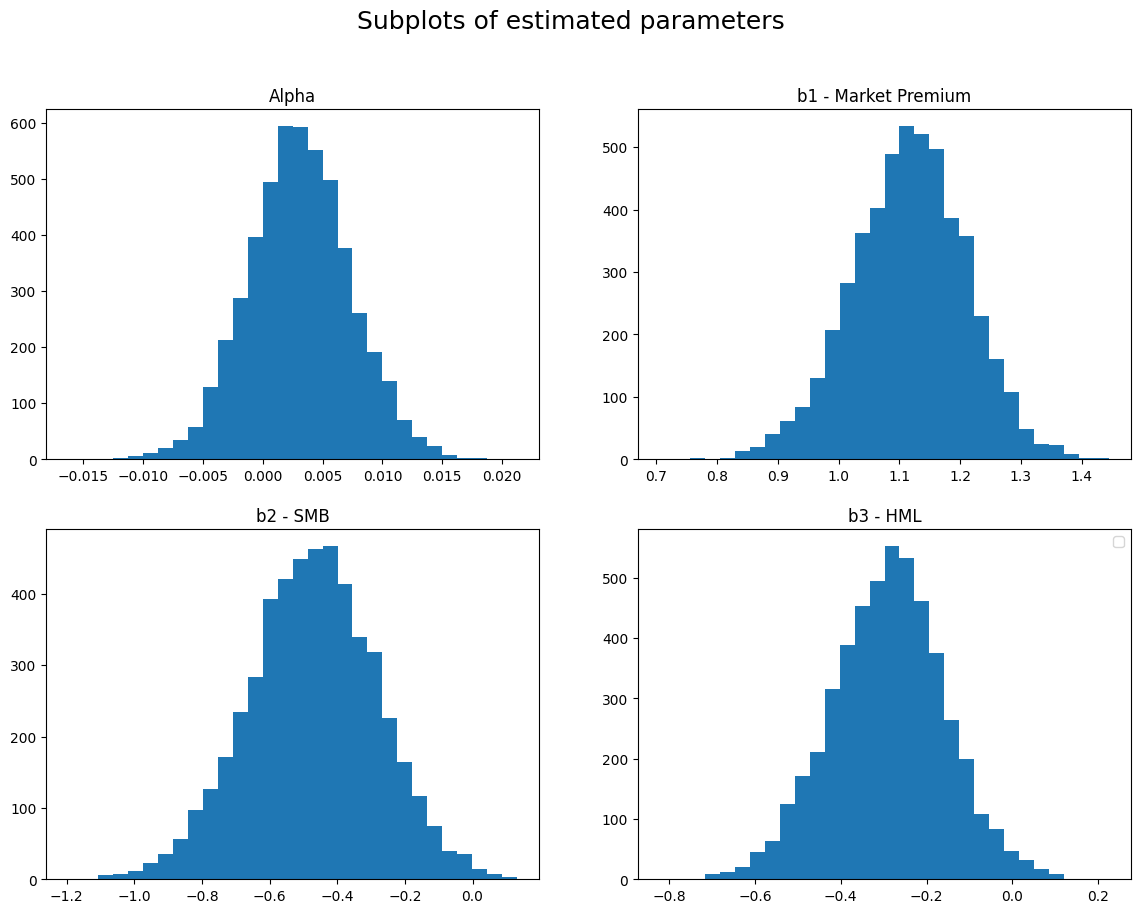

In [67]:
# Assuming data and tickers are defined elsewhere
data['returns'] = data[tickers[0]] - data['RF']

# Define variables to be filled with the simulations
boot_betas = []
mod_beta = 0
boot_return = 0
boot_returns = []

# Loop B times
for i in range(5000):
    sample = data.sample(n=len(data), replace=True)
    sample_means = sample.mean()  # Used to create the manual regression

    boot_model = sm.OLS(sample['returns'], sm.add_constant(
        sample[factors]))  # Removed the risk-free rate
    boot_result = boot_model.fit()

    mod_beta = boot_result.params
    boot_betas.append(mod_beta)

    # Use.iloc[] for positional access
    boot_return = mod_beta.iloc[1]*sample_means['Mkt-RF'] + mod_beta.iloc[2] * \
        sample_means['SMB'] + mod_beta.iloc[3]*sample_means['HML']
    boot_returns.append(boot_return)

# Normality test:
r_test = stats.normaltest(boot_returns)

boot_betas = pd.DataFrame(boot_betas)  # Convert results to a dataframe

# Visualize results distributions:
plt.figure()
fig4, axs = plt.subplots(2, 2)
axs[0, 0].hist(boot_betas['const'], bins=30)
axs[0, 0].set_title('Alpha')
axs[0, 1].hist(boot_betas['Mkt-RF'], bins=30)
axs[0, 1].set_title('b1 - Market Premium')
axs[1, 0].hist(boot_betas['SMB'], bins=30)
axs[1, 0].set_title('b2 - SMB')
axs[1, 1].hist(boot_betas['HML'], bins=30)
axs[1, 1].set_title('b3 - HML')
fig4.suptitle('Subplots of estimated parameters', fontsize=18)
plt.legend()

### Тест на нормальность

In [68]:
tests = boot_betas.apply(stats.normaltest)

for i in range(0, len(tests.iloc[1, :])):
    if tests.iloc[1, i] < 0.05:
        print(tests.columns[i], " is not normaly distributed")
    else:
        print(tests.columns[i], " is normaly distributed")

print(tests)

const  is normaly distributed
Mkt-RF  is not normaly distributed
SMB  is normaly distributed
HML  is normaly distributed
      const     Mkt-RF       SMB       HML
0  5.449000  15.591376  5.153632  5.369232
1  0.065579   0.000412  0.076016  0.068247


In [69]:
# bias correction
z_hat = norm.ppf(np.mean(boot_betas['HML'] < HML))  # measure of skewness

# jackknife
index = np.arange(len(X))  # create index array
beta_i = np.zeros(len(factors))
beta_jn = []

for i in range(len(X)):

    model_i = sm.OLS(Y[index != i], X[index != i])

    result_i = model_i.fit()
    beta_i = result_i.params
    beta_jn.append(beta_i)

beta_jn = pd.DataFrame(beta_jn)

# acceleration:
ql = norm.ppf(0.05)  # get standard normal values at given percentile
qu = norm.ppf(0.95)

beta_bar = beta_jn.apply(np.mean)

num = sum((beta_bar['HML'] - beta_jn['HML'])**3)
denom = 6 * sum((beta_bar['HML'] - beta_jn['HML'])**2)**(3/2)

a_hat = num / denom

l1 = norm.cdf(z_hat + (z_hat + ql)/(1-a_hat*(z_hat+ql)))
u1 = norm.cdf(z_hat + (z_hat + qu)/(1-a_hat*(z_hat+qu)))

print('Lowest coef value with 0.1 level of significance is: ',
      np.percentile(boot_betas['HML'], (l1*100)))
print('Highest coef value with 0.1 level of significance is:', np.percentile(boot_betas['HML'],(u1*100)))

Lowest coef value with 0.1 level of significance is:  -0.5312937738045193
Highest coef value with 0.1 level of significance is: -0.09404216357466692


Text(0.5, 1.0, 'Histogram of the bootsrapped HML coefficients')

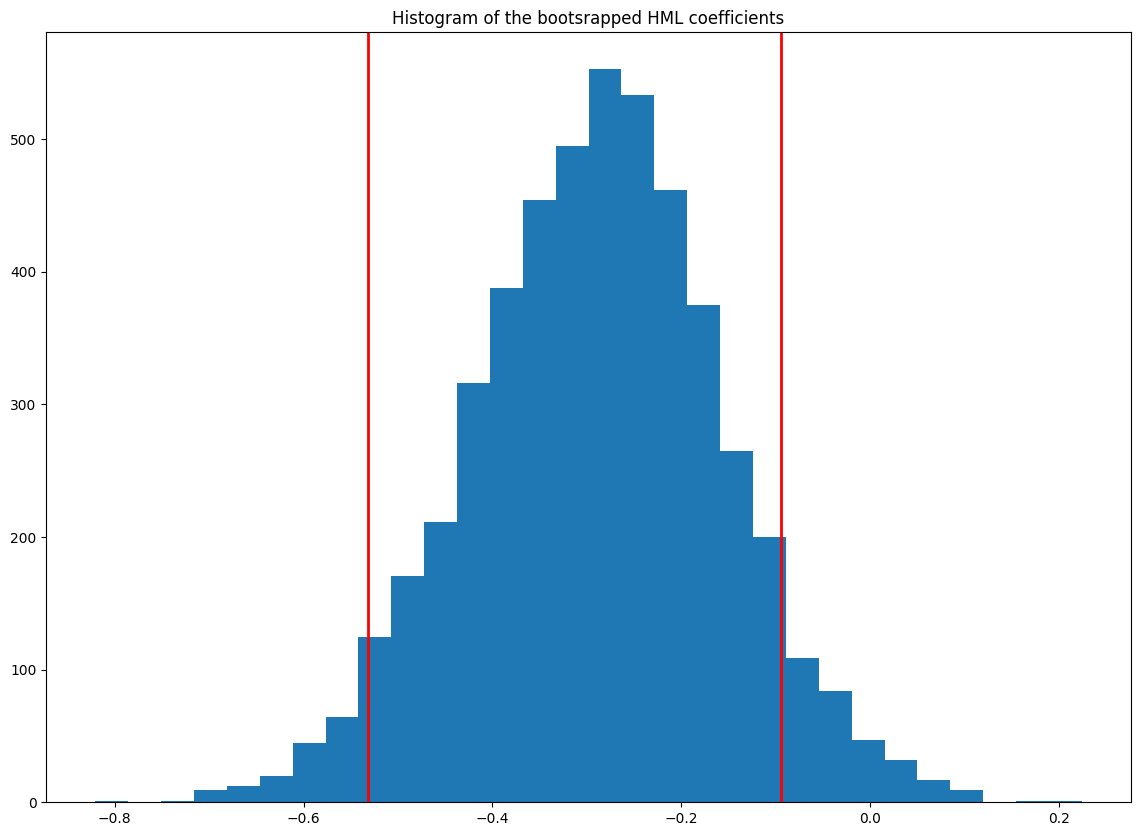

In [70]:
plt.figure()
plt.hist(boot_betas['HML'], bins=30)
plt.axvline(np.percentile(boot_betas['HML'],
            (l1*100)), color='red', linewidth=2)
plt.axvline(np.percentile(boot_betas['HML'],
            (u1*100)), color='red', linewidth=2)
plt.title('Histogram of the bootsrapped HML coefficients')

Как мы видим из гистограммы смоделированного распределения параметров HML, значение 0 не попадает в диапазон альфа-уровня 0,05. Вероятность фактического наблюдения 0 весьма мала. Давайте посчитаем.

In [71]:
print('Total percentage of estimations that are equal to, or are above 0 is: ', sum(boot_betas['HML'] >= 0) / len(boot_betas['HML']))

Total percentage of estimations that are equal to, or are above 0 is:  0.0156


Теперь мы количественно оценили неопределенность, связанную с параметрами нашей модели. Это может варьироваться от моделирования к моделированию, но общий эффект неопределенности в выборке фиксируется, что может помочь нам принять решение на основе модели - например, теперь, когда мы знаем, что вероятность коэффициент вряд ли будет равен 0, мы могли бы принять решение включить его в оценку доходности.

### Simulated returns

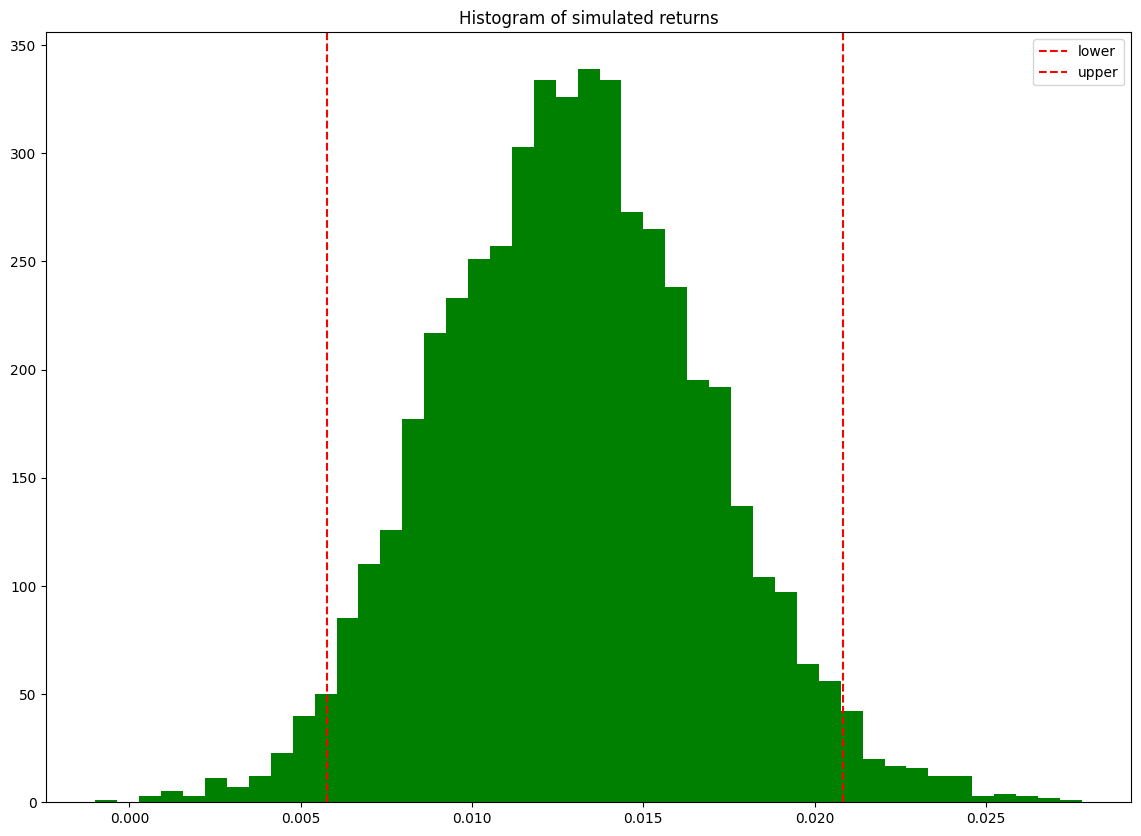

In [72]:
plt.figure()
plt.hist(boot_returns, alpha=1, bins=45, color='green')
plt.axvline(np.percentile(boot_returns, 2.5), color='red', linestyle='--')
plt.axvline(np.percentile(boot_returns, 97.5), color='red', linestyle='--')
plt.title('Histogram of simulated returns')
plt.legend(['lower', 'upper'])

Распределение симуляций ненормальное. Это соответствует исходным данным – распределение тоже не нормальное.

In [73]:
print('The occurances where asset returns fall below 0 are: ',
      sum(np.array(boot_returns) <= 0 / len(boot_returns)))
print(f'The average of expected monthly bootstrap return for {stock} is:', np.array(
    boot_returns).mean())

print("The pessimistic estimation for Alphabet stock montly returns is: ",
      np.percentile(boot_returns, 2.5))
print("The optimistic estimation for Alphabet stock montly returns is: ", np.percentile(boot_returns,97.5))

The occurances where asset returns fall below 0 are:  1
The average of expected monthly bootstrap return for GOOGL is: 0.0129845178651037
The pessimistic estimation for Alphabet stock montly returns is:  0.0057834461198435095
The optimistic estimation for Alphabet stock montly returns is:  0.020845299079165228


### Заключение:

Используя метод начальной загрузки, мы получили немного менее смещенную оценку доходности, а также верхнюю и нижнюю границу нашего прогноза. Мы также количественно оценили неопределенность относительно параметров нашей модели. Вопрос о том, является ли используемая модель адекватной и заслуживающей доверия для принятия решений, возможно, лучше всего решать квалифицированному эксперту в предметной области.